In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from pprint import pprint
tf.random.set_seed(1234)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam,Nadam
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_auc_score,roc_curve

#Read the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/MyDrive/Training/extracted_df.csv')

First, we will drop the index column "Unnamed: 0", "Q_num" and "URL".

Second, we will encode the "Rank" column.


#Data Investigation

In [4]:
df.shape

(2479, 6)

In [5]:
df.nunique()

Unnamed: 0    2479
Q_num          103
Rank             4
Answer        1896
Question      1805
URL            919
dtype: int64

In [6]:
len_rank=df['Rank'].nunique()
len_rank

4

In [7]:
count_rank=df['Rank'].value_counts()
count_rank

1-Incorrect     1436
2-Related        678
3-Incomplete     223
4-Excellent      142
Name: Rank, dtype: int64

In [8]:
df.describe()

,Unnamed: 0,Q_num
count,2479.000000,2479.000000
mean,1239.000000,51.393304
std,715.769982,29.858339
min,0.000000,1.000000
25%,619.500000,26.000000
50%,1239.000000,50.000000
75%,1858.500000,77.000000
max,2478.000000,104.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2479 non-null   int64 
 1   Q_num       2479 non-null   int64 
 2   Rank        2479 non-null   object
 3   Answer      2479 non-null   object
 4   Question    2479 non-null   object
 5   URL         2479 non-null   object
dtypes: int64(2), object(4)
memory usage: 116.3+ KB


In [10]:
df.isnull().any().sum()

0

In [11]:
df.duplicated().sum()

0

# Data Preprocessing

## Data Cleaning

In [12]:
#Dropping columns
df.drop(columns=["Unnamed: 0", "Q_num", "URL"], inplace=True)

#Encoding "Rank" column
for i in range (len(df)):
  df['Rank'].values[i]=df['Rank'].values[i][0]

df['Rank']=df['Rank'].astype(int)
df['Rank']=df['Rank']-1

## Train-Test Split
We'll split by ratio 8:2 
**Note that:** By doing some math, we will put the test size as 36% as we will up sample the training set later on. After all, the real split would be 8:2 

In [13]:
train, test = train_test_split(
    df, test_size=0.35, random_state=42)


In [14]:
train['Rank'].value_counts()

0    929
1    447
2    140
3     95
Name: Rank, dtype: int64

In [15]:
#Assign samples of each class to a new variable then convert it to numpy array
class_0=train[train['Rank']==0]
class_1=train[train['Rank']==1]
class_2=train[train['Rank']==2]
class_3=train[train['Rank']==3]

In [16]:
class_3=train[train['Rank']==3]
class_3

,Rank,Answer,Question
1430,3,"The ""First""Outbreak\n \nIn May 1993, an outbr...",what is the history of hps for Hantavirus ?
221,3,"Strep is short for Streptococcus, a type of ba...",What is (are) Streptococcal Infections ? (Also...
2372,3,The health care provider will do a physical ex...,How to diagnose Autoimmune disorders ?
1978,3,Prediabetes means your blood glucose levels ar...,What is (are) Diabetes ?
447,3,"Swimmer's ear is inflammation, irritation, or ...",What is (are) Swimmer's ear ? (Also called: Ea...
...,...,...,...
1570,3,More than 90% of children with trisomy 13 die ...,What is the outlook for Trisomy 13 ? (Also cal...
502,3,There is no known prevention for Beckwith-Wied...,How to prevent Beckwith-Wiedemann syndrome ?
2278,3,Summary : An upper GI and small bowel series i...,Do you have information about Upper GI and sma...
995,3,Keep all appointments with your doctor and the...,What other information should I know about Met...


In [17]:
#Upsampling the minority class
from sklearn.utils import resample
min_cls1_upsampled = resample(class_1,
             replace=True,
             n_samples=len(class_0),
             random_state=42)

min_cls2_upsampled = resample(class_2,
             replace=True,
             n_samples=len(class_0),
             random_state=42)

min_cls3_upsampled = resample(class_3,
             replace=True,
             n_samples=len(class_0),
             random_state=42)

print(min_cls1_upsampled.shape,min_cls2_upsampled.shape,min_cls3_upsampled.shape)
print(class_0.shape)

(929, 3) (929, 3) (929, 3)
(929, 3)


In [18]:
train= pd.concat([min_cls1_upsampled,min_cls2_upsampled,min_cls3_upsampled, class_0])
train.shape

(3716, 3)

##Assign Train and Test Data

In [19]:
xtr=train.loc[:, train.columns != 'Rank']
ytr=train.loc[:, train.columns == 'Rank']

xts=df.loc[:, test.columns != 'Rank']
yts=df.loc[:, test.columns == 'Rank']

##Data Preprocessing for NLP model
vocab size:	the maximum number of words to keep, based on word frequency 40k 


In [20]:
# preprocess text data

vocab_sizeQ = 100000
vocab_sizeA=150000
max_lenQ = 100
max_lenA = 250


# build vocabulary from training set
tokenizerQ = Tokenizer(num_words=vocab_sizeQ)
tokenizerQ.fit_on_texts(xtr['Question'])

tokenizerA = Tokenizer(num_words=vocab_sizeA)
tokenizerA.fit_on_texts(xtr['Answer'])


def Q_preprocess(list_of_text):
    return pad_sequences(
        tokenizerQ.texts_to_sequences(list_of_text),
        maxlen=max_lenQ,
        padding='post',
    )

def A_preprocess(list_of_text):
    return pad_sequences(
        tokenizerA.texts_to_sequences(list_of_text),
        maxlen=max_lenA,
        padding='post',
    )   

# padding is done inside: 
pre_Q = Q_preprocess(xtr['Question'])
pre_A = A_preprocess(xtr['Answer'])
print(pre_Q.shape)
print(pre_A.shape)

(3716, 100)
(3716, 250)


In [21]:
# we can use the tokenizer to convert IDs to words.
pprint(tokenizerQ.sequences_to_texts(pre_Q[:5]))
print("===================================")
pprint(tokenizerA.sequences_to_texts(pre_A[:5]))

['what causes fibromyalgia also called fibromyositis fibrositis',
 'what is are autoimmune hepatitis',
 'what to do in case of emergency or overdose of calcitonin salmon nasal spray',
 'how can i learn more about shingles zoster vaccine',
 'what causes joint swelling also called swelling of a joint']
['the cause is unknown possible causes or triggers of fibromyalgia include '
 'physical or emotional trauma abnormal pain response areas in the brain that '
 'control pain may react differently in people with fibromyalgia sleep '
 'disturbances infection such as a virus although none has been identified '
 'fibromyalgia is most common among women age 20 to 50 the following '
 'conditions may be seen with fibromyalgia or have similar symptoms chronic '
 'neck or back pain chronic fatigue syndrome depression hypothyroidism '
 'underactive thyroid lyme disease sleep disorders',
 'at any age however it most often starts in adolescence or young adulthood '
 'about 70 percent of people with type

In [22]:
print('total words in the questions dictionary:', tokenizerQ.num_words)
print('total words in the answers dictionary:', tokenizerA.num_words)

total words in the questions dictionary: 100000
total words in the answers dictionary: 150000


In [23]:
#Preprocess test data
pre_Qt = Q_preprocess(xts['Question'])
pre_At = A_preprocess(xts['Answer'])

# Building The NLP Model

In [24]:
in_Q = keras.Input(batch_shape=(None, max_lenQ))
in_A = keras.Input(batch_shape=(None, max_lenA))
# Bidirectional LSTMs are an extension of traditional LSTMs that can improve model
# performance on sequence classification problems.
embedded1 = keras.layers.Embedding(tokenizerQ.num_words, 100)(in_Q)
lstm = keras.layers.LSTM(32, return_sequences=True)(embedded1)
lstm1 = keras.layers.LSTM(64, return_sequences=False) (lstm)
#bidirectional2 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=False))(embedded1)#(bidirectional1)
fc1 = Dense(100, activation='relu')(lstm1)
print(fc1)
embedded2 = keras.layers.Embedding(tokenizerA.num_words, 100)(in_A)
merged = keras.layers.Concatenate(axis=1)([embedded1, embedded2])
lstm2 = keras.layers.LSTM(32, return_sequences=True)(embedded2)
lstm3 = keras.layers.LSTM(64, return_sequences=False)(lstm2)
#bidirectional5 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=False))(embedded2)#(bidirectional4)
fc2 = Dense(100, activation='relu')(lstm3)


fused = keras.layers.Concatenate(axis=1)([fc1, fc2])

rank = Dense(len_rank, activation='softmax', name='type')(fused)

model = keras.Model(
    inputs={
        'Question':in_Q,
        'Answer':in_A
    },
    outputs=rank
)

model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy', 
    metrics='SparseCategoricalAccuracy' 

)

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense/Relu:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     10000000    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 250, 100)  

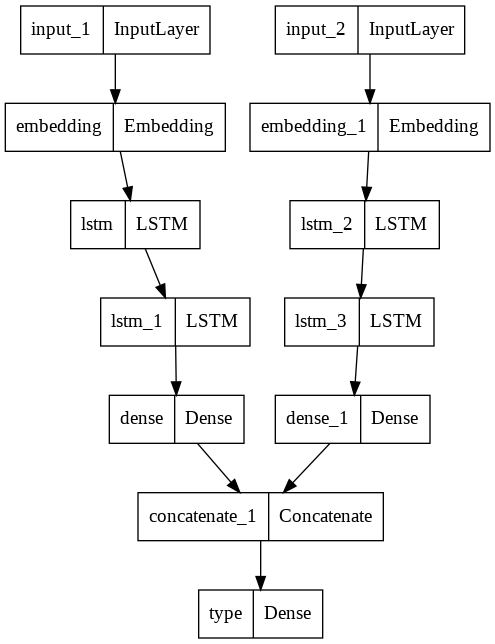

In [25]:
tf.keras.utils.plot_model(
model, to_file='model.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

## Bidirectional Model Training

In [26]:
history = model.fit(
    x={
        'Question': pre_Q,
        'Answer': pre_A
    },
    y=ytr,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6,restore_best_weights=True )
    ],
    verbose=1
)

Epoch 1/50
93/93 [==============================] - 48s 430ms/step - loss: 1.2305 - sparse_categorical_accuracy: 0.3668 - val_loss: 2.6464 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/50
93/93 [==============================] - 38s 409ms/step - loss: 1.1507 - sparse_categorical_accuracy: 0.4226 - val_loss: 2.9767 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/50
93/93 [==============================] - 38s 409ms/step - loss: 1.1046 - sparse_categorical_accuracy: 0.4512 - val_loss: 2.6638 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/50
93/93 [==============================] - 40s 431ms/step - loss: 1.0813 - sparse_categorical_accuracy: 0.4670 - val_loss: 2.7075 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/50
93/93 [==============================] - 40s 429ms/step - loss: 1.0484 - sparse_categorical_accuracy: 0.4690 - val_loss: 2.9508 - val_sparse_categorical_accuracy: 0.0242
Epoch 6/50
93/93 [==============================] - 40s 435ms/step - loss: 1.02

In [27]:
y_predict = model.predict(
    {
        'Question': pre_Qt,
        'Answer': pre_At
    }
)

In [28]:
model.evaluate(
        x={
        'Question': pre_Qt,
        'Answer': pre_At
        }, 
        y=yts)

78/78 [==============================] - 5s 61ms/step - loss: 1.6987 - sparse_categorical_accuracy: 0.3707


[1.698747992515564, 0.370714008808136]

In [29]:
y_predict=np.argmax(y_predict, axis=1)

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(yts, y_predict) ## confusion matrix
class_report = classification_report(yts,y_predict,zero_division=1) ## classification report
print("Confusion matrix\n\n" ,conf_matrix , "\n")
print(class_report)

Confusion matrix

 [[ 223 1173   33    7]
 [  23  635   15    5]
 [   6  178   33    6]
 [   8  104    2   28]] 

              precision    recall  f1-score   support

           0       0.86      0.16      0.26      1436
           1       0.30      0.94      0.46       678
           2       0.40      0.15      0.22       223
           3       0.61      0.20      0.30       142

    accuracy                           0.37      2479
   macro avg       0.54      0.36      0.31      2479
weighted avg       0.65      0.37      0.31      2479



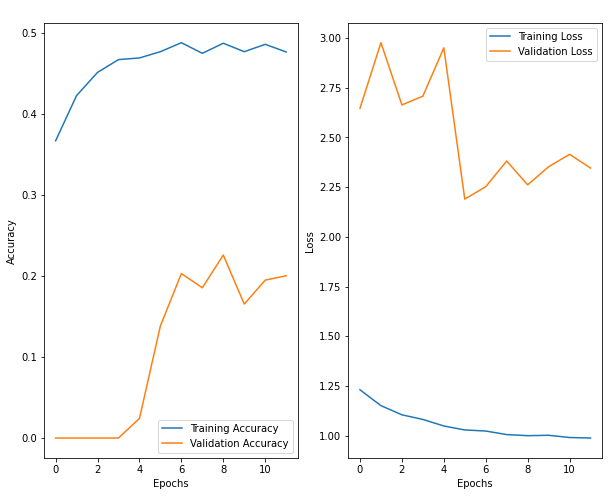

In [31]:
# Plotting  model training accuracy and validation accuracy curves with epochs 
plt.figure(figsize=(10, 8), )
plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('                         ')

# Plotting  model training loss and validation loss curves with epoch
plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.show()